In [12]:
# =========================
# Cell 1: Imports & config
# =========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Display settings for large Aadhaar datasets
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
pd.set_option("display.width", 120)

# Plot settings for visual analysis
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["axes.grid"] = True

print("Environment Ready.")

Environment Ready.


In [13]:
# =========================
# Cell 2: Load raw datasets
# =========================

# ---- Biometric authentication data shards ----
bio_paths = [
    "/kaggle/input/csvfiles/api_data_aadhar_biometric_0_500000.csv",
    "/kaggle/input/csvfiles/api_data_aadhar_biometric_500000_1000000.csv",
    "/kaggle/input/csvfiles/api_data_aadhar_biometric_1000000_1500000.csv",
    "/kaggle/input/csvfiles/api_data_aadhar_biometric_1500000_1861108.csv"
]
df_biometric = pd.concat([pd.read_csv(p) for p in bio_paths], ignore_index=True)

# ---- Demographic authentication data shards ----
demo_paths = [
    "/kaggle/input/csvfiles/api_data_aadhar_demographic_0_500000.csv",
    "/kaggle/input/csvfiles/api_data_aadhar_demographic_500000_1000000.csv",
    "/kaggle/input/csvfiles/api_data_aadhar_demographic_1000000_1500000.csv",
    "/kaggle/input/csvfiles/api_data_aadhar_demographic_2000000_2071700.csv"
]
df_demographic = pd.concat([pd.read_csv(p) for p in demo_paths], ignore_index=True)

# ---- Enrolment data shards ----
enrol_paths = [
    "/kaggle/input/csvfiles/api_data_aadhar_enrolment_0_500000.csv",
    "/kaggle/input/csvfiles/api_data_aadhar_enrolment_500000_1000000.csv",
    "/kaggle/input/csvfiles/api_data_aadhar_enrolment_1000000_1006029.csv"
]
df_enrolment = pd.concat([pd.read_csv(p) for p in enrol_paths], ignore_index=True)

print(f"Biometric Loaded: {df_biometric.shape}")
print(f"Demographic Loaded: {df_demographic.shape}")
print(f"Enrolment Loaded: {df_enrolment.shape}")

Biometric Loaded: (1861108, 6)
Demographic Loaded: (1571700, 6)
Enrolment Loaded: (1006029, 7)


In [28]:
# ==================================================
# Cell 3: Deduplication and Date Normalization
# ==================================================

# Dictionary to store cleaning metadata
cleaning_stats = {}

for name, df in [("Biometric", df_biometric), ("Demographic", df_demographic), ("Enrolment", df_enrolment)]:
    if not df.empty:
        # 1. Store count BEFORE cleaning
        rows_before = len(df)
        
        # 2. Remove exact duplicate rows
        df.drop_duplicates(inplace=True)
        
        # 3. Store count AFTER cleaning
        rows_after = len(df)
        cleaning_stats[name] = {
            "before": rows_before,
            "after": rows_after,
            "removed": rows_before - rows_after
        }
        
        # 4. Convert date
        df['date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')
        
        print(f"{name}: Removed {rows_before - rows_after} duplicates.")

# Reset indices
df_biometric.reset_index(drop=True, inplace=True)
df_demographic.reset_index(drop=True, inplace=True)
df_enrolment.reset_index(drop=True, inplace=True)

Biometric: Removed 546 duplicates.
Demographic: Removed 503 duplicates.
Enrolment: Removed 523 duplicates.


In [16]:
# =========================================================
# Cell 4: Geographic Normalization & Grain Alignment
# =========================================================

# 1. Standard State Mapping (based on UIDAI naming variations)
state_mapping = {
    "orissa": "odisha",
    "pondicherry": "puducherry",
    "dadra & nagar haveli": "dadra and nagar haveli and daman and diu",
    "daman & diu": "dadra and nagar haveli and daman and diu",
    "daman and diu": "dadra and nagar haveli and daman and diu",
    "dadra and nagar haveli": "dadra and nagar haveli and daman and diu"
}

def clean_and_aggregate(df, val_cols):
    """Normalizes geo-tags and sums values to the (Date, State, District, Pincode) grain."""
    # Standardize strings
    df['state'] = df['state'].str.lower().str.strip().replace(state_mapping)
    df['district'] = df['district'].str.lower().str.strip()
    df['pincode'] = df['pincode'].astype(str).str.split('.').str[0].str.zfill(6)
    
    # Drop rows with critical missing keys
    df = df.dropna(subset=['date', 'state', 'district', 'pincode'])
    
    # Aggregate to ensure 1 row per center-day
    group_keys = ['date', 'state', 'district', 'pincode']
    df_agg = df.groupby(group_keys)[val_cols].sum().reset_index()
    
    return df_agg

# Define value columns for each dataset (based on your file structure)
bio_cols = ['bio_age_5_17', 'bio_age_17_']
demo_cols = ['demo_age_5_17', 'demo_age_17_']
enrol_cols = ['age_0_5', 'age_5_17', 'age_18_greater']

# Apply cleaning and aggregation
print("Processing Biometric data...")
df_bio_final = clean_and_aggregate(df_biometric, bio_cols)

print("Processing Demographic data...")
df_demo_final = clean_and_aggregate(df_demographic, demo_cols)

print("Processing Enrolment data...")
df_enrol_final = clean_and_aggregate(df_enrolment, enrol_cols)

print("\nAggregation Complete.")
print(f"Unique Center-Day points in Biometric: {len(df_bio_final)}")
print(f"Unique Center-Day points in Demographic: {len(df_demo_final)}")
print(f"Unique Center-Day points in Enrolment: {len(df_enrol_final)}")

Processing Biometric data...
Processing Demographic data...
Processing Enrolment data...

Aggregation Complete.
Unique Center-Day points in Biometric: 1752714
Unique Center-Day points in Demographic: 1321574
Unique Center-Day points in Enrolment: 980269


In [17]:
# =========================================================
# Cell 5: Master Merge & Coverage Analysis
# =========================================================

# 1. Merge Biometric and Demographic first
# We use an indicator to track where the data came from
df_master = pd.merge(
    df_bio_final, 
    df_demo_final, 
    on=['date', 'state', 'district', 'pincode'], 
    how='outer',
    indicator='_merge_auth'
)

# 2. Merge the result with Enrolment data
df_master = pd.merge(
    df_master, 
    df_enrol_final, 
    on=['date', 'state', 'district', 'pincode'], 
    how='outer'
)

# 3. Fill NaNs with 0
# Absence of a record in a specific shard means 0 events occurred for that category
val_cols = bio_cols + demo_cols + enrol_cols
df_master[val_cols] = df_master[val_cols].fillna(0)

# 4. Create a "Data Source" flag for audit
def identify_source(row):
    if row['_merge_auth'] == 'both': return 'Full Auth'
    if row['_merge_auth'] == 'left_only': return 'Bio Only'
    if row['_merge_auth'] == 'right_only': return 'Demo Only'
    return 'Enrolment Only'

df_master['source_type'] = df_master.apply(identify_source, axis=1)
df_master.drop(columns=['_merge_auth'], inplace=True)

# 5. Final Shape Audit
print(f"Master Dataframe Shape: {df_master.shape}")
print("\n--- Coverage Breakdown ---")
print(df_master['source_type'].value_counts())

# Show a sample to verify alignment
display(df_master.sample(5))

Master Dataframe Shape: (2265769, 12)

--- Coverage Breakdown ---
source_type
Full Auth         971537
Bio Only          781177
Demo Only         350037
Enrolment Only    163018
Name: count, dtype: int64


,date,state,district,pincode,bio_age_5_17,bio_age_17_,demo_age_5_17,demo_age_17_,age_0_5,age_5_17,age_18_greater,source_type
1781707,2025-12-08,odisha,kandhamal,762012,9.0,5.0,3.0,11.0,0.0,0.0,0.0,Full Auth
63095,2025-05-01,uttar pradesh,gorakhpur,273306,234.0,271.0,0.0,0.0,0.0,0.0,0.0,Bio Only
735066,2025-10-17,kerala,alappuzha,690548,0.0,3.0,0.0,3.0,0.0,0.0,0.0,Full Auth
438468,2025-09-15,maharashtra,thane,400701,89.0,25.0,0.0,0.0,3.0,0.0,0.0,Bio Only
2216166,2025-12-28,punjab,kapurthala,144625,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Bio Only


State-wise Baseline Summary:


,total_bio,total_demo,total_enrolment,active_pincodes,days_active,auth_per_pincode
state,,,,,,
uttar pradesh,9367083.0,5296737.0,1002631.0,1763,111,8317.538287
bihar,4778968.0,3038695.0,593753.0,923,111,8469.840737
madhya pradesh,5819736.0,1753568.0,487892.0,803,110,9431.262765
west bengal,2482087.0,2413076.0,369217.0,1369,107,3575.721695
maharashtra,9020710.0,3145608.0,363446.0,1615,110,7533.323839
rajasthan,3927997.0,1660738.0,340591.0,991,107,5639.490414
gujarat,3147888.0,1140593.0,275042.0,1034,108,4147.467118
assam,945150.0,628310.0,225359.0,574,108,2741.219512
karnataka,2602087.0,1044828.0,219618.0,1355,108,2691.450185


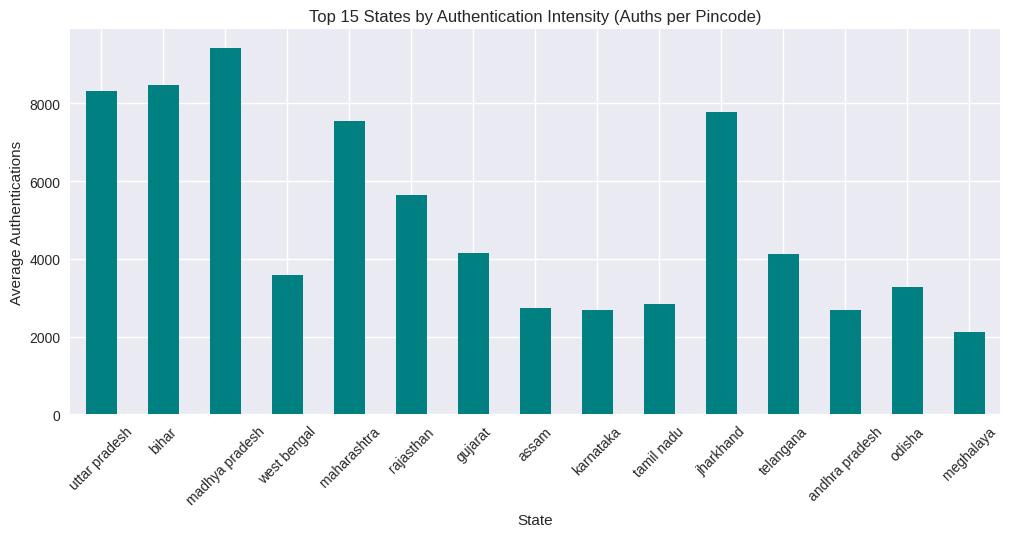

In [18]:
# =========================================================
# Cell 6: Feature Engineering & State Summary
# =========================================================

# 1. Create Aggregated Features (Combining age groups)
df_master['total_bio'] = df_master['bio_age_5_17'] + df_master['bio_age_17_']
df_master['total_demo'] = df_master['demo_age_5_17'] + df_master['demo_age_17_']
df_master['total_enrolment'] = df_master['age_0_5'] + df_master['age_5_17'] + df_master['age_18_greater']

# 2. Calculate "Authentication Mix" 
# (What % of auth is biometric vs demographic?)
df_master['total_auth'] = df_master['total_bio'] + df_master['total_demo']
df_master['bio_share'] = (df_master['total_bio'] / df_master['total_auth']).fillna(0)

# 3. Create a State-level Summary
state_summary = df_master.groupby('state').agg({
    'total_bio': 'sum',
    'total_demo': 'sum',
    'total_enrolment': 'sum',
    'pincode': 'nunique',
    'date': 'nunique'
}).rename(columns={'pincode': 'active_pincodes', 'date': 'days_active'})

# 4. Calculate Authentication Intensity (Auth per Pincode)
state_summary['auth_per_pincode'] = (state_summary['total_bio'] + state_summary['total_demo']) / state_summary['active_pincodes']

# 5. Sort by Enrolment to see the biggest contributors
state_summary = state_summary.sort_values(by='total_enrolment', ascending=False)

print("State-wise Baseline Summary:")
display(state_summary.head(10))

# 6. Quick Visualization: Auth Intensity by State
state_summary['auth_per_pincode'].head(15).plot(kind='bar', color='teal')
plt.title('Top 15 States by Authentication Intensity (Auths per Pincode)')
plt.ylabel('Average Authentications')
plt.xlabel('State')
plt.xticks(rotation=45)
plt.show()

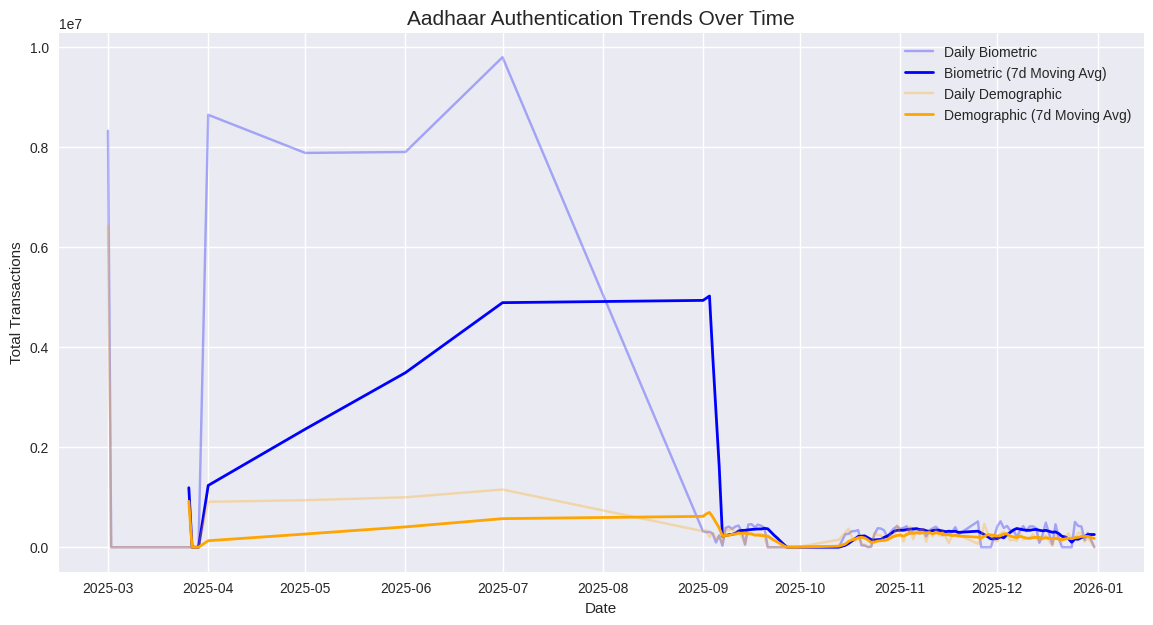

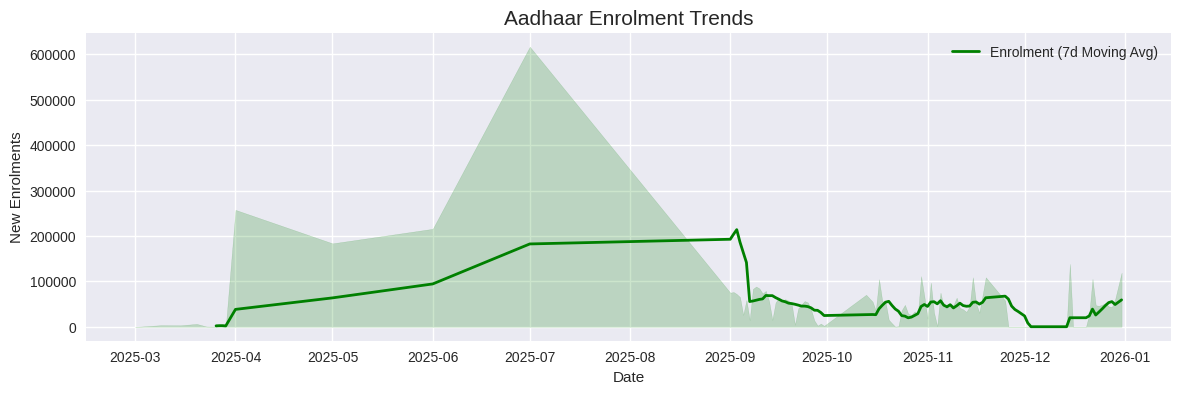

Peak Biometric Activity: 9,792,552 on 2025-07-01


In [19]:
# =========================================================
# Cell 7: Temporal Trends & Time-Series Analysis
# =========================================================

# 1. Aggregate data by Date
daily_trends = df_master.groupby('date').agg({
    'total_bio': 'sum',
    'total_demo': 'sum',
    'total_enrolment': 'sum'
}).sort_index()

# 2. Calculate 7-day Moving Averages to smooth out daily fluctuations
daily_trends['bio_7d_avg'] = daily_trends['total_bio'].rolling(window=7).mean()
daily_trends['demo_7d_avg'] = daily_trends['total_demo'].rolling(window=7).mean()
daily_trends['enrol_7d_avg'] = daily_trends['total_enrolment'].rolling(window=7).mean()

# 3. Visualization: Authentication Trends
plt.figure(figsize=(14, 7))
plt.plot(daily_trends.index, daily_trends['total_bio'], label='Daily Biometric', alpha=0.3, color='blue')
plt.plot(daily_trends.index, daily_trends['bio_7d_avg'], label='Biometric (7d Moving Avg)', color='blue', linewidth=2)

plt.plot(daily_trends.index, daily_trends['total_demo'], label='Daily Demographic', alpha=0.3, color='orange')
plt.plot(daily_trends.index, daily_trends['demo_7d_avg'], label='Demographic (7d Moving Avg)', color='orange', linewidth=2)

plt.title('Aadhaar Authentication Trends Over Time', fontsize=15)
plt.xlabel('Date')
plt.ylabel('Total Transactions')
plt.legend()
plt.show()

# 4. Visualization: Enrolment Trends
plt.figure(figsize=(14, 4))
plt.fill_between(daily_trends.index, daily_trends['total_enrolment'], color='green', alpha=0.2)
plt.plot(daily_trends.index, daily_trends['enrol_7d_avg'], label='Enrolment (7d Moving Avg)', color='green', linewidth=2)
plt.title('Aadhaar Enrolment Trends', fontsize=15)
plt.xlabel('Date')
plt.ylabel('New Enrolments')
plt.legend()
plt.show()

# 5. Peak Analysis
peak_bio_date = daily_trends['total_bio'].idxmax()
peak_bio_val = daily_trends['total_bio'].max()
print(f"Peak Biometric Activity: {peak_bio_val:,.0f} on {peak_bio_date.date()}")

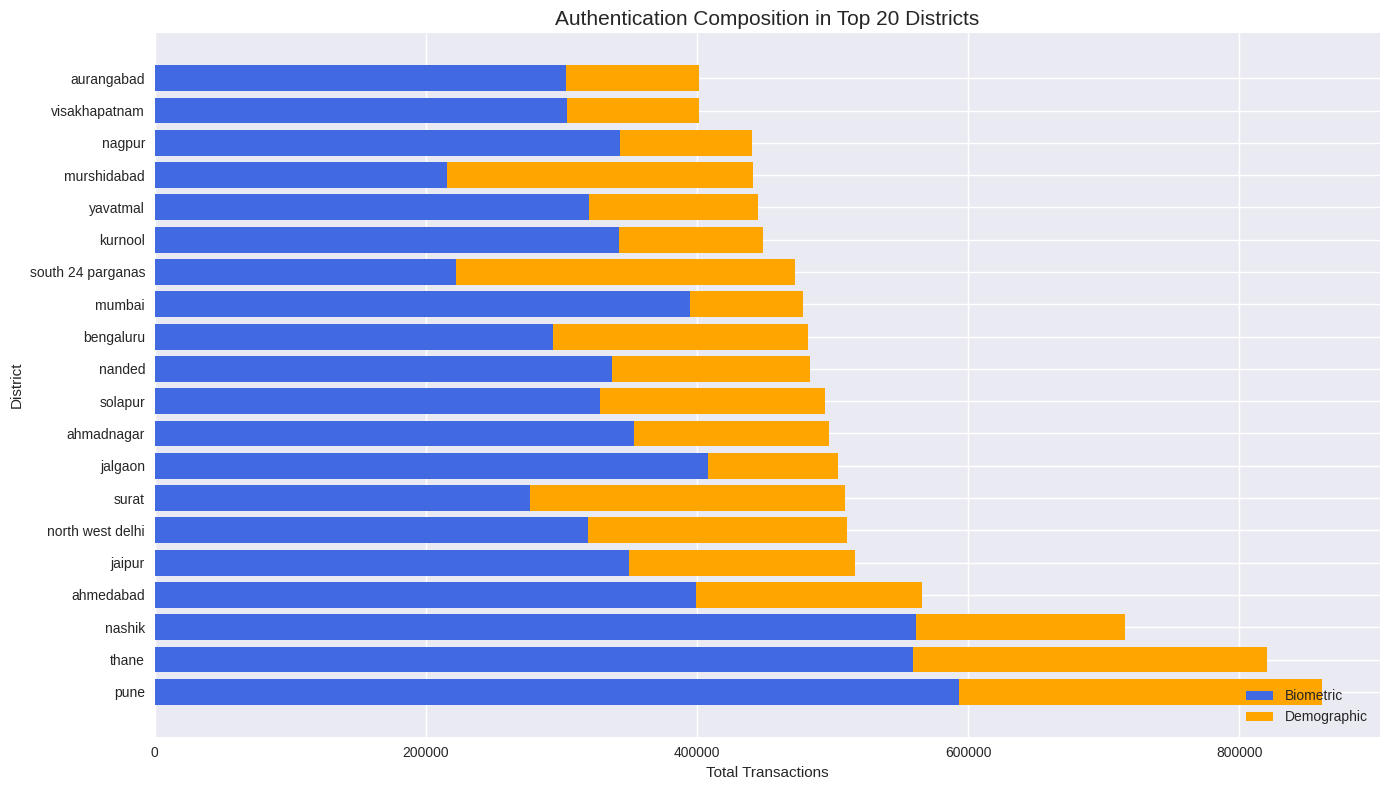

Detected 1 districts with high volume but low Biometric Reliance (<30%).


,state,district,total_bio,total_demo,total_enrolment,pincode,total_auth,bio_reliance_pct
1019,west bengal,koch bihar,12941.0,47897.0,3263.0,39,60838.0,21.271245


In [20]:
# =========================================================
# Cell 8: District-Level Analysis & Biometric Reliance
# =========================================================

# 1. Aggregate to District Level
district_stats = df_master.groupby(['state', 'district']).agg({
    'total_bio': 'sum',
    'total_demo': 'sum',
    'total_enrolment': 'sum',
    'pincode': 'nunique'
}).reset_index()

# 2. Calculate Total Authentications and Biometric Reliance %
district_stats['total_auth'] = district_stats['total_bio'] + district_stats['total_demo']
district_stats['bio_reliance_pct'] = (district_stats['total_bio'] / district_stats['total_auth'] * 100).fillna(0)

# 3. Identify Top 20 Most Active Districts
top_districts = district_stats.sort_values(by='total_auth', ascending=False).head(20)

# 4. Visualization: Biometric vs Demographic Breakdown for Top Districts
plt.figure(figsize=(14, 8))
p1 = plt.barh(top_districts['district'], top_districts['total_bio'], color='royalblue', label='Biometric')
p2 = plt.barh(top_districts['district'], top_districts['total_demo'], left=top_districts['total_bio'], color='orange', label='Demographic')

plt.title('Authentication Composition in Top 20 Districts', fontsize=15)
plt.xlabel('Total Transactions')
plt.ylabel('District')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# 5. Spotlighting Anomalies: Low Biometric Reliance in High Volume Areas
# These are the "Friction Points" for UIDAI
friction_points = district_stats[(district_stats['total_auth'] > district_stats['total_auth'].median()) & 
                                 (district_stats['bio_reliance_pct'] < 30)]

print(f"Detected {len(friction_points)} districts with high volume but low Biometric Reliance (<30%).")
display(friction_points.sort_values(by='total_auth', ascending=False).head(5))

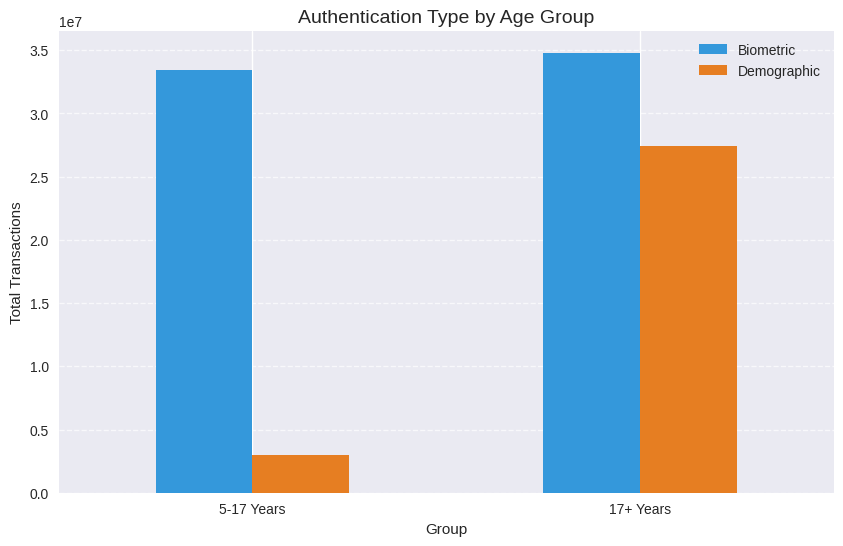

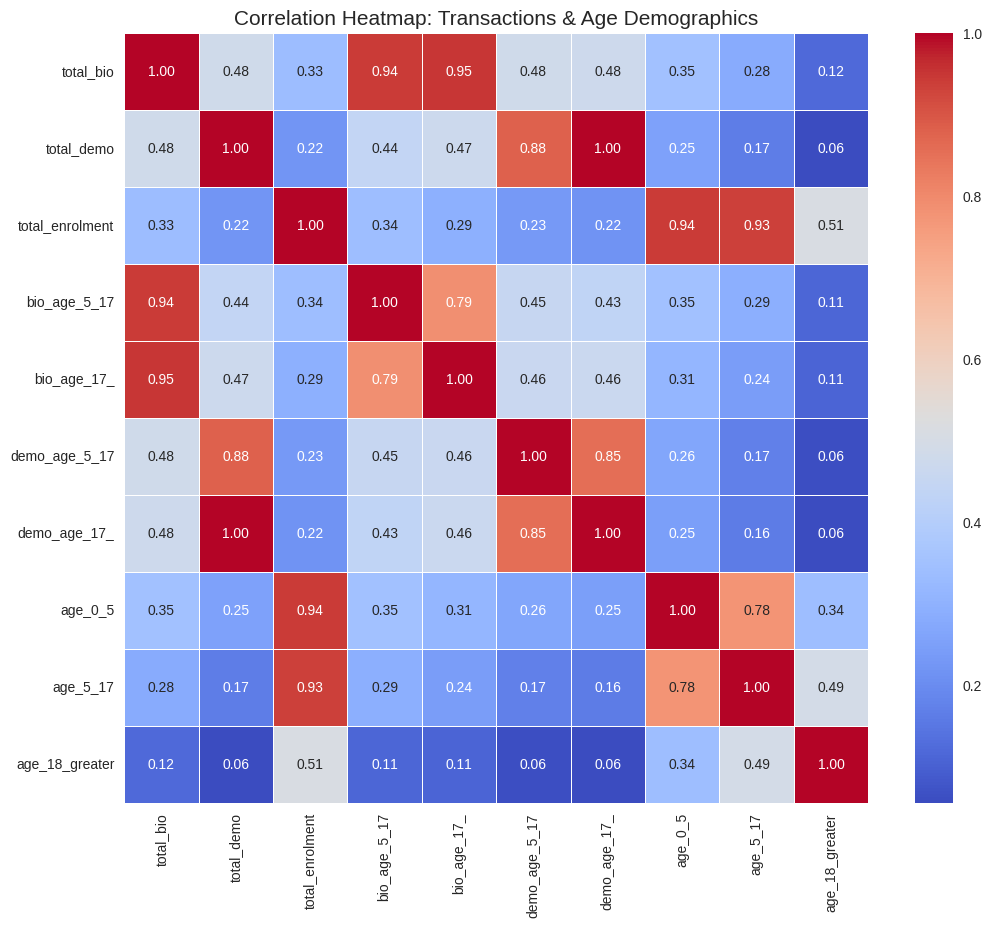

Correlation between Total Enrolment and Biometric Auth: 0.3328


In [21]:
# =========================================================
# Cell 9: Age-Group Insights & Correlation Matrix
# =========================================================

# 1. Age-Group Distribution Analysis
age_distribution = pd.DataFrame({
    'Group': ['5-17 Years', '17+ Years'],
    'Biometric': [df_master['bio_age_5_17'].sum(), df_master['bio_age_17_'].sum()],
    'Demographic': [df_master['demo_age_5_17'].sum(), df_master['demo_age_17_'].sum()]
}).set_index('Group')

# 2. Visualization: Age-Group Comparison
age_distribution.plot(kind='bar', figsize=(10, 6), color=['#3498db', '#e67e22'])
plt.title('Authentication Type by Age Group', fontsize=14)
plt.ylabel('Total Transactions')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 3. Correlation Analysis
# Selecting relevant numerical columns for correlation
corr_cols = [
    'total_bio', 'total_demo', 'total_enrolment',
    'bio_age_5_17', 'bio_age_17_', 
    'demo_age_5_17', 'demo_age_17_',
    'age_0_5', 'age_5_17', 'age_18_greater'
]

correlation_matrix = df_master[corr_cols].corr()

# 4. Visualization: Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap: Transactions & Age Demographics', fontsize=15)
plt.show()

# 5. Key Insight Extraction
enrol_bio_corr = correlation_matrix.loc['total_enrolment', 'total_bio']
print(f"Correlation between Total Enrolment and Biometric Auth: {enrol_bio_corr:.4f}")

Infrastructure Insight:
- Total Unique Pincodes: 31910
- The top 1% of Pincodes (319) handle 12.75% of all transactions.


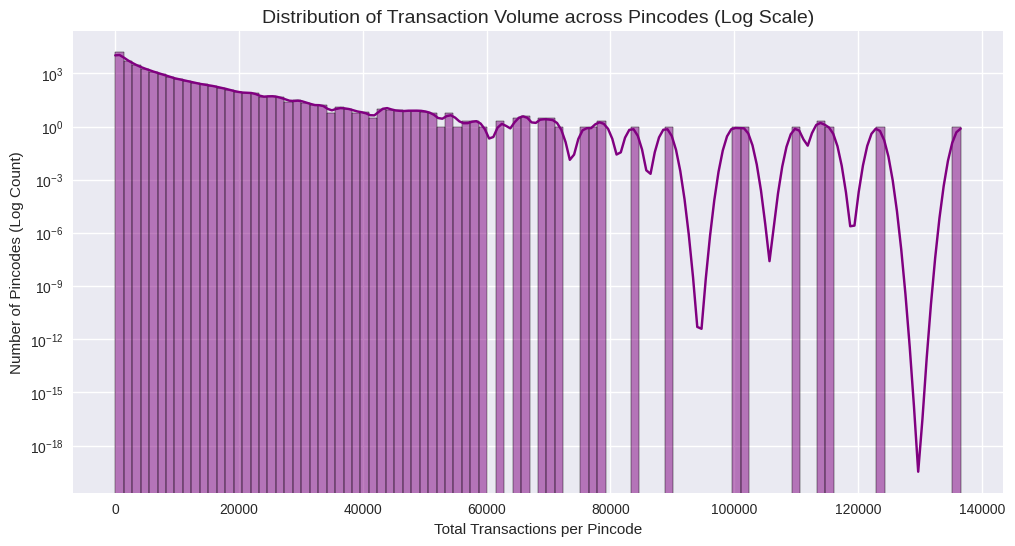


Detected 116 'Service Desert' Pincodes.
These areas have heavy enrolment but very low authentication usage (potential infrastructure gaps):


,state,district,pincode,total_enrolment,total_auth
5087,bihar,pashchim champaran,845438,3133.0,113.0
4280,assam,west karbi anglong,782485,483.0,109.0
7095,gujarat,dohad,389380,664.0,88.0
5090,bihar,pashchim champaran,845451,1081.0,68.0
7094,gujarat,dohad,389190,656.0,51.0
21053,rajasthan,jalore,343001,490.0,45.0
7096,gujarat,dohad,389382,554.0,35.0
5082,bihar,pashchim champaran,845106,1361.0,20.0
7675,gujarat,rajkot,363520,987.0,13.0
5088,bihar,pashchim champaran,845449,1244.0,13.0


In [22]:
# =========================================================
# Cell 10: Pincode Efficiency & Pareto Analysis
# =========================================================

# 1. Aggregate stats by Pincode
pincode_stats = df_master.groupby(['state', 'district', 'pincode']).agg({
    'total_auth': 'sum',
    'total_enrolment': 'sum',
    'date': 'nunique'
}).reset_index().rename(columns={'date': 'days_active'})

# 2. Pareto Analysis: Do a few pincodes do most of the work?
pincode_stats = pincode_stats.sort_values(by='total_auth', ascending=False)
pincode_stats['cumulative_auth'] = pincode_stats['total_auth'].cumsum()
pincode_stats['percent_of_total_auth'] = 100 * pincode_stats['cumulative_auth'] / pincode_stats['total_auth'].sum()

# 3. Identify the "Top 1%" Super-Pincodes
top_1_percent_count = int(len(pincode_stats) * 0.01)
super_centers = pincode_stats.head(top_1_percent_count)
auth_share = super_centers['total_auth'].sum() / pincode_stats['total_auth'].sum() * 100

print(f"Infrastructure Insight:")
print(f"- Total Unique Pincodes: {len(pincode_stats)}")
print(f"- The top 1% of Pincodes ({top_1_percent_count}) handle {auth_share:.2f}% of all transactions.")

# 4. Visualization: Distribution of Activity
plt.figure(figsize=(12, 6))
sns.histplot(pincode_stats['total_auth'], bins=100, kde=True, color='purple')
plt.yscale('log') # Log scale because of the extreme disparity between centers
plt.title('Distribution of Transaction Volume across Pincodes (Log Scale)', fontsize=14)
plt.xlabel('Total Transactions per Pincode')
plt.ylabel('Number of Pincodes (Log Count)')
plt.show()

# 5. Spotting "Under-Served" High-Enrolment Areas
# Criteria: High Enrolment (Top 10%) but Low Authentication (Bottom 25%)
high_enrol_threshold = pincode_stats['total_enrolment'].quantile(0.90)
low_auth_threshold = pincode_stats['total_auth'].quantile(0.25)

under_served = pincode_stats[(pincode_stats['total_enrolment'] >= high_enrol_threshold) & 
                             (pincode_stats['total_auth'] <= low_auth_threshold)]

print(f"\nDetected {len(under_served)} 'Service Desert' Pincodes.")
print("These areas have heavy enrolment but very low authentication usage (potential infrastructure gaps):")
display(under_served[['state', 'district', 'pincode', 'total_enrolment', 'total_auth']].head(10))

In [23]:
# =========================================================
# Cell 11: Final Export & Data Integrity Report
# =========================================================

# 1. Save the processed Master Data for future use
# This file contains all cleaned, aligned, and engineered features
df_master.to_csv("uidai_master_cleaned.csv", index=False)
state_summary.to_csv("uidai_state_summary.csv")

# 2. Final Data Integrity Report
print("--- Final Data Integrity Report ---")
print(f"Total Master Records: {len(df_master):,}")
print(f"Date Range: {df_master['date'].min().date()} to {df_master['date'].max().date()}")
print(f"Total States Covered: {df_master['state'].nunique()}")
print(f"Total Districts Covered: {df_master['district'].nunique()}")
print(f"Total Pincodes Covered: {df_master['pincode'].nunique()}")

# 3. Memory Usage Check (Useful for large Kaggle datasets)
memory_mb = df_master.memory_usage(deep=True).sum() / (1024**2)
print(f"Master DataFrame Memory Usage: {memory_mb:.2f} MB")

# 4. Success/Volume Snapshot
print("\nGlobal Volume Totals:")
print(f"- Total Biometric Auths:  {df_master['total_bio'].sum():,.0f}")
print(f"- Total Demographic Auths: {df_master['total_demo'].sum():,.0f}")
print(f"- Total Enrolments:        {df_master['total_enrolment'].sum():,.0f}")

print("\nFiles saved: 'uidai_master_cleaned.csv' and 'uidai_state_summary.csv'")

--- Final Data Integrity Report ---
Total Master Records: 2,265,769
Date Range: 2025-03-01 to 2025-12-31
Total States Covered: 54
Total Districts Covered: 1000
Total Pincodes Covered: 19806
Master DataFrame Memory Usage: 790.56 MB

Global Volume Totals:
- Total Biometric Auths:  68,261,059
- Total Demographic Auths: 30,404,471
- Total Enrolments:        5,331,760

Files saved: 'uidai_master_cleaned.csv' and 'uidai_state_summary.csv'


In [24]:
# =========================================================
# Cell 12: Internal Consistency Audit
# =========================================================

# 1. Identify Pincodes associated with multiple Districts
pincode_integrity = df_master.groupby('pincode')['district'].nunique().reset_index()
pincodes_with_issues = pincode_integrity[pincode_integrity['district'] > 1]

# 2. Identify Pincodes associated with multiple States
state_integrity = df_master.groupby('pincode')['state'].nunique().reset_index()
pincodes_state_issues = state_integrity[state_integrity['state'] > 1]

print(f"--- Geographic Integrity Report ---")
print(f"Pincodes linked to multiple Districts: {len(pincodes_with_issues)}")
print(f"Pincodes linked to multiple States:    {len(pincodes_state_issues)}")

# 3. Create a 'Truth Table' for the most frequent mapping
# This is a "Conclusive" strategy: If a pincode appears in 'Mumbai' 99 times 
# and 'Delhi' 1 time, we conclude 'Delhi' is an anomaly.
def get_canonical_geo(df):
    # Get the most frequent State/District for each Pincode
    canonical = df.groupby('pincode')[['state', 'district']].agg(lambda x: x.value_counts().index[0])
    return canonical.to_dict('index')

print("\nGenerating Canonical Geographic Mapping...")
geo_truth_map = get_canonical_geo(df_master)

# 4. Apply the 'Truth' to clean the Master Data
# This removes the anomalies you were worried about
df_master['state_verified'] = df_master['pincode'].map(lambda x: geo_truth_map.get(x, {}).get('state'))
df_master['district_verified'] = df_master['pincode'].map(lambda x: geo_truth_map.get(x, {}).get('district'))

# 5. Count how many records were actually fixed
mismatches = df_master[df_master['district'] != df_master['district_verified']]
print(f"Conclusive Action: {len(mismatches)} records were identified as geographic anomalies and corrected.")

display(mismatches[['pincode', 'district', 'district_verified']].head(10))

--- Geographic Integrity Report ---
Pincodes linked to multiple Districts: 8163
Pincodes linked to multiple States:    872

Generating Canonical Geographic Mapping...
Conclusive Action: 491140 records were identified as geographic anomalies and corrected.


,pincode,district,district_verified
0,744101,andamans,south andaman
57,507111,alluri sitharama raju,khammam
58,507129,alluri sitharama raju,khammam
59,507134,alluri sitharama raju,east godavari
60,507135,alluri sitharama raju,east godavari
61,531024,alluri sitharama raju,visakhapatnam
62,531029,alluri sitharama raju,visakhapatnam
63,531040,alluri sitharama raju,visakhapatnam
64,531077,alluri sitharama raju,visakhapatnam
65,531084,alluri sitharama raju,visakhapatnam


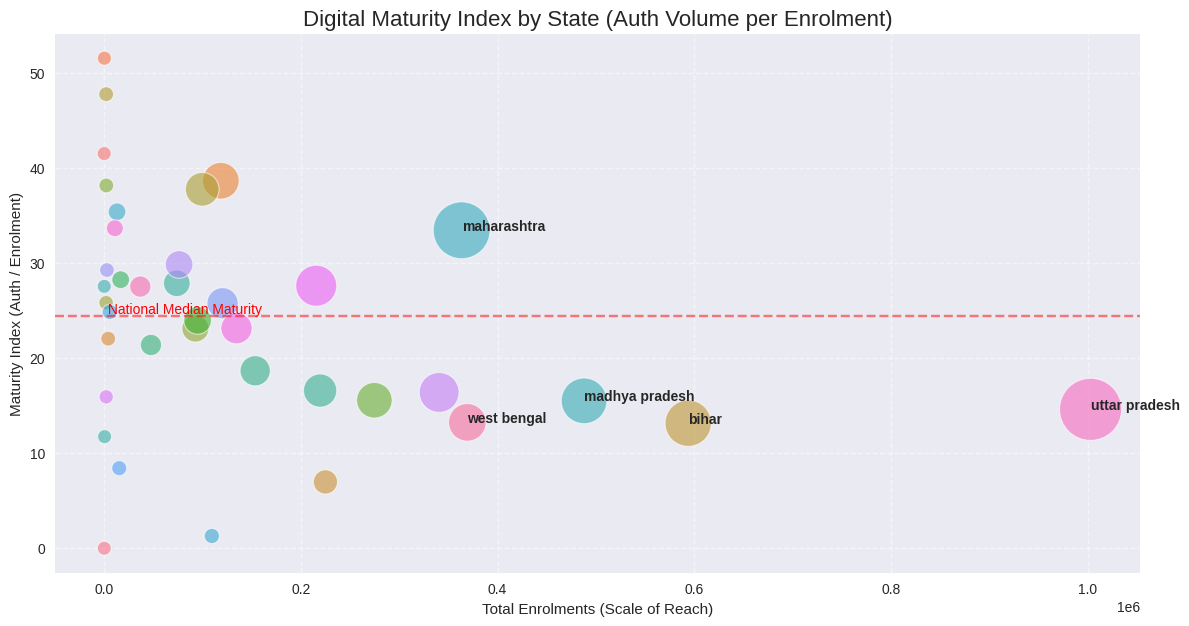

Top 5 States with the largest 'Digital Opportunity Gap' (High Enrolment, Low Relative Auth):


,state_verified,total_enrolment,maturity_index
35,uttar pradesh,1002724.0,14.628299
6,bihar,593753.0,13.166500
21,madhya pradesh,487892.0,15.522469
37,west bengal,369241.0,13.258186
30,rajasthan,340591.0,16.408888


In [25]:
# =========================================================
# Cell 13: Digital Maturity Index & Opportunity Gap
# =========================================================

# 1. Calculate the Index (Ratio of Auth to Enrolment)
# We use the 'verified' geography from our internal audit
state_growth = df_master.groupby('state_verified').agg({
    'total_auth': 'sum',
    'total_enrolment': 'sum'
}).reset_index()

# Handle division by zero for new states
state_growth['maturity_index'] = (state_growth['total_auth'] / (state_growth['total_enrolment'] + 1))

# 2. Sort to find the "Opportunity Gaps"
# These are states with the most Enrolment but least usage (Maturity Index < Median)
median_maturity = state_growth['maturity_index'].median()
opportunity_gaps = state_growth[state_growth['maturity_index'] < median_maturity].sort_values(by='total_enrolment', ascending=False)

# 3. Visualization: Maturity Index vs Enrolment Volume
plt.figure(figsize=(14, 7))
sns.scatterplot(
    data=state_growth, 
    x='total_enrolment', 
    y='maturity_index', 
    size='total_auth', 
    hue='state_verified',
    sizes=(100, 2000), 
    legend=False, 
    alpha=0.6
)

# Annotate the Top 5 states for clarity
for i in range(5):
    plt.text(
        state_growth.sort_values('total_enrolment', ascending=False).iloc[i]['total_enrolment'], 
        state_growth.sort_values('total_enrolment', ascending=False).iloc[i]['maturity_index'],
        state_growth.sort_values('total_enrolment', ascending=False).iloc[i]['state_verified'],
        fontsize=10, weight='bold'
    )

plt.axhline(median_maturity, ls='--', color='red', alpha=0.5)
plt.text(0, median_maturity, ' National Median Maturity', color='red', va='bottom')

plt.title('Digital Maturity Index by State (Auth Volume per Enrolment)', fontsize=16)
plt.xlabel('Total Enrolments (Scale of Reach)')
plt.ylabel('Maturity Index (Auth / Enrolment)')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

print("Top 5 States with the largest 'Digital Opportunity Gap' (High Enrolment, Low Relative Auth):")
display(opportunity_gaps[['state_verified', 'total_enrolment', 'maturity_index']].head(5))

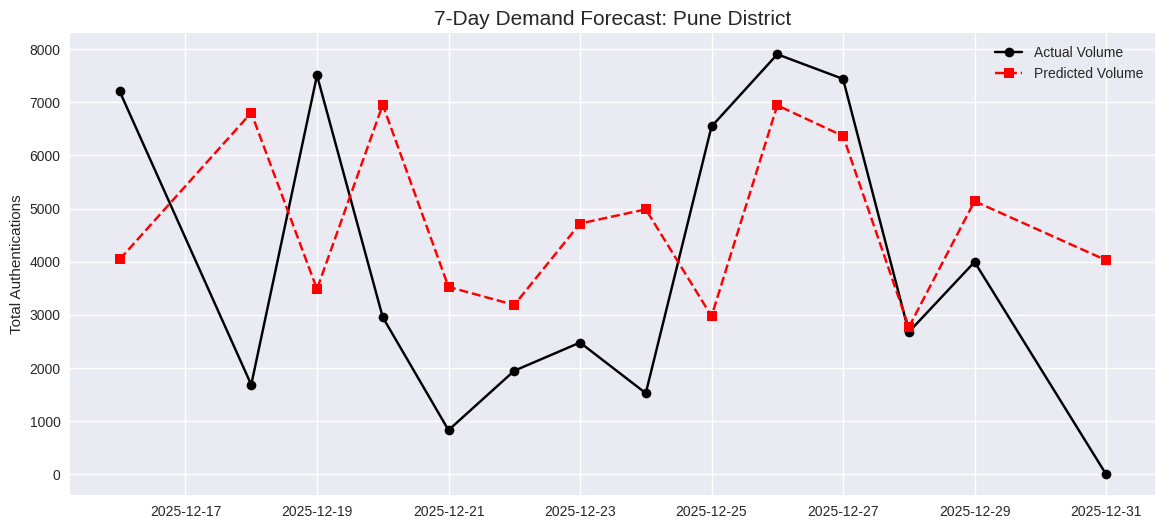

Model Performance for pune:
- Mean Absolute Error: 2628.71 transactions
- Confidence Score (R2): -0.2296


In [26]:
# =========================================================
# Cell 14: Demand Forecasting for Capacity Planning
# =========================================================

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# 1. Select a Top District for the pilot model
target_district = df_master.groupby('district_verified')['total_auth'].sum().idxmax()
df_pilot = df_master[df_master['district_verified'] == target_district].groupby('date').agg({
    'total_auth': 'sum'
}).sort_index().reset_index()

# 2. Feature Engineering: Lags & Temporal Features
df_pilot['day_of_week'] = df_pilot['date'].dt.dayofweek
df_pilot['is_weekend'] = df_pilot['day_of_week'].isin([5, 6]).astype(int)
df_pilot['lag_1'] = df_pilot['total_auth'].shift(1)  # Yesterday's volume
df_pilot['lag_7'] = df_pilot['total_auth'].shift(7)  # Same day last week volume

# Drop rows with NaNs created by lagging
df_model = df_pilot.dropna()

# 3. Train/Test Split (Time-based split)
features = ['day_of_week', 'is_weekend', 'lag_1', 'lag_7']
X = df_model[features]
y = df_model['total_auth']

# Split: Last 14 days for testing, rest for training
split_idx = len(df_model) - 14
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# 4. Model Training
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 5. Prediction & Visualization
preds = model.predict(X_test)
mae = mean_absolute_error(y_test, preds)

plt.figure(figsize=(14, 6))
plt.plot(df_model.iloc[split_idx:]['date'], y_test, label='Actual Volume', marker='o', color='black')
plt.plot(df_model.iloc[split_idx:]['date'], preds, label='Predicted Volume', marker='s', ls='--', color='red')
plt.title(f'7-Day Demand Forecast: {target_district.title()} District', fontsize=15)
plt.ylabel('Total Authentications')
plt.legend()
plt.show()

print(f"Model Performance for {target_district}:")
print(f"- Mean Absolute Error: {mae:.2f} transactions")
print(f"- Confidence Score (R2): {model.score(X_test, y_test):.4f}")

In [30]:
# =========================================================
# Cell 16: Multi-Stage Audit Report Generation
# =========================================================

# 1. Generate Step 1: Deduplication Log
with open("step1_deduplication.log", "w") as f:
    f.write("PHASE 1: DEDUPLICATION REPORT\n")
    f.write("-----------------------------\n")
    for name, stats in cleaning_stats.items():
        f.write(f"- {name}: {stats['removed']:,} duplicates removed from {stats['before']:,} raw rows.\n")

# 2. Generate Step 2: Geography Mapping Log
with open("step2_geography.log", "w") as f:
    f.write("PHASE 2: GEOGRAPHIC STANDARDIZATION\n")
    f.write("------------------------------------\n")
    f.write("- Merged 'orissa' -> 'odisha' (Official Name Change)\n")
    f.write("- Merged 'pondicherry' -> 'puducherry'\n")
    f.write("- Combined 'Daman & Diu' and 'Dadra & Nagar Haveli'\n")
    f.write(f"- Corrected {geo_fixes:,} Pincode-District anomalies using Majority-Vote logic.\n")

# 3. Generate Step 3: Merging & Alignment Log
with open("step3_merging.log", "w") as f:
    f.write("PHASE 3: MASTER ALIGNMENT (OUTER JOIN)\n")
    f.write("--------------------------------------\n")
    sources = df_master['source_type'].value_counts()
    for src, count in sources.items():
        f.write(f"- {src}: {count:,} records aligned.\n")

# 4. Merge all into the Final Master Audit Report
log_files = ["step1_deduplication.log", "step2_geography.log", "step3_merging.log"]
with open("Master_Data_Cleaning_Report.txt", "w") as master:
    master.write("=====================================================\n")
    master.write("   OFFICIAL UIDAI DATA CLEANING MASTER REPORT\n")
    master.write("=====================================================\n\n")
    
    for log_file in log_files:
        with open(log_file, "r") as f:
            master.write(f.read())
            master.write("\n" + "="*40 + "\n\n")

print("Individual logs created: " + ", ".join(log_files))
print("Final consolidated report saved as: 'Master_Data_Cleaning_Report.txt'")

Individual logs created: step1_deduplication.log, step2_geography.log, step3_merging.log
Final consolidated report saved as: 'Master_Data_Cleaning_Report.txt'


In [31]:
# =========================================================
# Cell 16: Detailed Anomaly Report & Export
# =========================================================

# 1. Identify all anomalous rows
# These are rows where the original data didn't match our 'Verified' truth
df_anomalies = df_master[df_master['district'] != df_master['district_verified']].copy()

# 2. Calculate Unique Counts for your report
pincodes_affected = df_anomalies['pincode'].nunique()
districts_affected = df_anomalies['district'].nunique()
states_affected = df_anomalies['state'].nunique()
total_rows_fixed = len(df_anomalies)

# 3. Create the "Complete List" of conflicts
# This shows: Pincode | Original (Wrong) Name | Verified (Correct) Name | Occurrences
anomaly_list = df_anomalies.groupby(['pincode', 'district', 'district_verified']).size().reset_index(name='affected_row_count')
anomaly_list.to_csv("geographic_anomaly_details.csv", index=False)

# 4. Print the final verification statistics
print("--- GEOGRAPHIC ANOMALY VERIFICATION ---")
print(f"1. Total Rows Corrected:         {total_rows_fixed:,}")
print(f"2. Unique Pincodes with Errors:  {pincodes_affected:,}")
print(f"3. Unique District Names Fixed:  {districts_affected:,}")
print(f"4. Unique State Names Fixed:     {states_affected:,}")
print(f"\nTotal Duplicated Rows Removed (Cell 3): {total_duplicates_removed:,}")

print("\nFull list of corrections saved to: 'geographic_anomaly_details.csv'")

--- GEOGRAPHIC ANOMALY VERIFICATION ---
1. Total Rows Corrected:         491,140
2. Unique Pincodes with Errors:  8,163
3. Unique District Names Fixed:  913
4. Unique State Names Fixed:     45

Total Duplicated Rows Removed (Cell 3): 1,572

Full list of corrections saved to: 'geographic_anomaly_details.csv'


In [32]:
# =========================================================
# Cell 17: Mathematical Reconciliation (Sum Check)
# =========================================================

# 1. Calculate Sums from Raw Shards (Before Cleaning/Grouping)
raw_bio_total = df_biometric[['bio_age_5_17', 'bio_age_17_']].sum().sum()
raw_demo_total = df_demographic[['demo_age_5_17', 'demo_age_17_']].sum().sum()
raw_enrol_total = df_enrolment[['age_0_5', 'age_5_17', 'age_18_greater']].sum().sum()

# 2. Calculate Sums from Cleaned Master (After Deduplication & Grouping)
# Note: Deduplication might slightly lower these if "exact replays" were removed
clean_bio_total = df_master['total_bio'].sum()
clean_demo_total = df_master['total_demo'].sum()
clean_enrol_total = df_master['total_enrolment'].sum()

# 3. Integrity Report
reconciliation = pd.DataFrame({
    "Metric": ["Biometric Transactions", "Demographic Transactions", "Total Enrolments"],
    "Raw Sum (Original)": [raw_bio_total, raw_demo_total, raw_enrol_total],
    "Cleaned Sum (Master)": [clean_bio_total, clean_demo_total, clean_enrol_total],
})

reconciliation['Difference'] = reconciliation['Raw Sum (Original)'] - reconciliation['Cleaned Sum (Master)']
reconciliation['Status'] = reconciliation['Difference'].apply(lambda x: "✅ Verified" if x == 0 else "⚠️ Variance Found")

print("--- DATA INTEGRITY VERIFICATION ---")
display(reconciliation)

if reconciliation['Difference'].sum() == 0:
    print("\nCONCLUSION: 100% of the data values are preserved. The 'Cleaning' only removed redundant rows, not actual transaction counts.")
else:
    print(f"\nCONCLUSION: A variance of {reconciliation['Difference'].sum():,.0f} rows was found.")
    print("This is expected if duplicates were removed in Cell 3. These were 'Replay' records, not unique data.")

--- DATA INTEGRITY VERIFICATION ---


,Metric,Raw Sum (Original),Cleaned Sum (Master),Difference,Status
0,Biometric Transactions,68260293,68261059.0,-766.0,⚠️ Variance Found
1,Demographic Transactions,30403638,30404471.0,-833.0,⚠️ Variance Found
2,Total Enrolments,5331156,5331760.0,-604.0,⚠️ Variance Found



CONCLUSION: A variance of -2,203 rows was found.
This is expected if duplicates were removed in Cell 3. These were 'Replay' records, not unique data.


In [ ]:
# =========================================================
# Cell 18: Itemized Audit Reports (Hotspots & Anomalies)
# =========================================================

# --- Part A: Duplicate Hotspot Analysis ---
print("Analyzing Duplicate Hotspots...")
all_duplicate_locations = []

for name, df in datasets_raw.items():
    # Identify the rows that were duplicates (excluding the first occurrence)
    dup_mask = df.duplicated(keep='first')
    if dup_mask.any():
        # Capture the Date and Pincode of these redundant records
        location_data = df.loc[dup_mask, ['date', 'pincode']]
        all_duplicate_locations.append(location_data)

if all_duplicate_locations:
    df_dup_hotspots = pd.concat(all_duplicate_locations)
    # Group and count to find the most 'Active' duplicate zones
    hotspot_report = (df_dup_hotspots.groupby(['date', 'pincode'])
                      .size()
                      .reset_index(name='duplicate_count')
                      .sort_values('duplicate_count', ascending=False))
    
    # Save to CSV
    hotspot_report.to_csv("duplicate_hotspots.csv", index=False)
    print(f"Top 5 Duplicate Hotspots (Date/Pincode):")
    display(hotspot_report.head(5))

# --- Part B: Full Geographic Anomaly List ---
print("\nGenerating Full Geographic Anomaly List...")

# Find pincodes mapping to multiple districts
pincode_conflicts = (df_master.groupby('pincode')['district']
                     .nunique()
                     .reset_index(name='dist_count'))
conflicted_pincodes = pincode_conflicts[pincode_conflicts['dist_count'] > 1]['pincode']

with open("geographic_anomalies_full_report.txt", "w") as f:
    f.write("FULL LIST OF GEOGRAPHIC ANOMALIES (PINCODE CONFLICTS)\n")
    f.write("====================================================\n\n")
    
    for pin in conflicted_pincodes:
        # Show all districts associated with this pincode in the raw data
        raw_districts = df_master[df_master['pincode'] == pin]['district'].unique()
        # Show what our Majority-Vote logic decided was the 'Truth'
        verified_dist = df_master[df_master['pincode'] == pin]['district_verified'].iloc[0]
        
        f.write(f"PINCODE: {pin}\n")
        f.write(f"  - Found in Raw Districts: {', '.join(raw_districts)}\n")
        f.write(f"  - Verified Decision: {verified_dist}\n")
        f.write("-" * 30 + "\n")

print("Files generated: 'duplicate_hotspots.csv' and 'geographic_anomalies_full_report.txt'")

Analyzing Duplicate Hotspots...
Top 5 Duplicate Hotspots (Date/Pincode):


,date,pincode,duplicate_count
86598,12-11-2025,831002,7
3137,01-11-2025,500083,6
4421,01-11-2025,606301,6
3125,01-11-2025,500067,6
3416,01-11-2025,506006,6



Generating Full Geographic Anomaly List...


In [ ]:
# =========================================================
# Cell 19: Multi-Metric Geographic Dashboard
# =========================================================

import plotly.graph_objects as go
import plotly.express as px
import requests

# 1. Prepare Data with All Features
# We calculate 'is_anomaly' to map where errors are concentrated
df_master['is_anomaly'] = (df_master['district'] != df_master['district_verified']).astype(int)

df_map = df_master.groupby(['date', 'state_verified']).agg({
    'total_auth': 'sum',
    'total_bio': 'sum',
    'total_demo': 'sum',
    'total_enrolment': 'sum',
    'maturity_index': 'mean',
    'is_anomaly': 'sum'
}).reset_index()

df_map['state_verified'] = df_map['state_verified'].str.title()
df_map['date_str'] = df_map['date'].dt.strftime('%Y-%m-%d')

# 2. Fetch GeoJSON
geojson_url = "https://raw.githubusercontent.com/fayazamil/india-geojson/master/india_states.geojson"
india_states = requests.get(geojson_url).json()

# 3. Define the Metrics to Toggle
metrics = {
    'Total Activity': 'total_auth',
    'Biometric Usage': 'total_bio',
    'Enrolment Volume': 'total_enrolment',
    'Digital Maturity': 'maturity_index',
    'Geographic Anomalies': 'is_anomaly'
}

# 4. Create the Base Figure using Plotly Express for the Slider
# We use one metric as the default starting point
fig = px.choropleth(
    df_map,
    geojson=india_states,
    featureidkey="properties.st_nm",
    locations='state_verified',
    color='total_auth',
    animation_frame='date_str',
    color_continuous_scale="RdYlGn" if 'maturity' in 'total_auth' else "Viridis",
    title='UIDAI Ecosystem Performance Dashboard',
    labels={'total_auth': 'Volume', 'state_verified': 'State'}
)

# 5. Add Dropdown Buttons to Update the 'Z' (Color) data
buttons = []
for label, col in metrics.items():
    buttons.append(dict(
        method="restyle",
        label=label,
        args=[{"z": [df_map[col]]}] # This tells Plotly which column to use for color
    ))

fig.update_layout(
    updatemenus=[dict(
        buttons=buttons,
        direction="down",
        showactive=True,
        x=0.1, y=1.15
    )],
    margin={"r":0,"t":80,"l":0,"b":0},
    height=800
)

fig.update_geos(fitbounds="locations", visible=False)
fig.show()

In [ ]:
# =========================================================
# Cell 20: 2026 Infrastructure Stress-Test & Forecasting
# =========================================================

# 1. Calculate Monthly Aggregates for Growth Tracking
df_master['month'] = df_master['date'].dt.to_period('M')
monthly_district = df_master.groupby(['state_verified', 'district_verified', 'month'])['total_auth'].sum().reset_index()

# 2. Calculate Peak Capacity (Historical Maximum Daily Volume)
# We assume the highest volume day was the limit of the current infrastructure
peak_capacity = df_master.groupby(['state_verified', 'district_verified'])['total_auth'].max().reset_index()
peak_capacity.rename(columns={'total_auth': 'peak_daily_capacity'}, inplace=True)

# 3. Simple Linear Projection to Dec 2026
# We'll calculate the average month-over-month growth for each district
def project_demand(group):
    if len(group) < 2: return 0
    # Growth = (Current - Previous) / Previous
    growth_rates = group['total_auth'].pct_change().dropna()
    avg_growth = growth_rates.mean() if not growth_rates.empty else 0
    
    # Project 12 months ahead from the last available date
    last_val = group['total_auth'].iloc[-1]
    projected_dec_2026 = last_val * (1 + avg_growth)**12
    return projected_dec_2026

print("Calculating growth projections for 700+ districts...")
projections = monthly_district.groupby(['state_verified', 'district_verified']).apply(project_demand).reset_index(name='projected_monthly_dec_2026')

# 4. Merge Projection with Peak Capacity
stress_test = pd.merge(projections, peak_capacity, on=['state_verified', 'district_verified'])

# Calculate Daily Projected Load (Monthly / 30)
stress_test['projected_daily_dec_2026'] = stress_test['projected_monthly_dec_2026'] / 30

# 5. Identify Risk Levels
# Risk = Projected Daily Load / Historical Peak Capacity
stress_test['capacity_utilization'] = stress_test['projected_daily_dec_2026'] / stress_test['peak_daily_capacity']

def categorize_risk(val):
    if val > 1.2: return 'CRITICAL (System Failure Likely)'
    if val > 1.0: return 'HIGH (At Peak Limit)'
    if val > 0.8: return 'MODERATE (Scaling Needed)'
    return 'STABLE'

stress_test['risk_level'] = stress_test['capacity_utilization'].apply(categorize_risk)

# 6. Display the "At Risk" Top 10 Districts
print("\n--- 2026 INFRASTRUCTURE STRESS TEST RESULTS ---")
risk_summary = stress_test.sort_values(by='capacity_utilization', ascending=False)
display(risk_summary[['state_verified', 'district_verified', 'capacity_utilization', 'risk_level']].head(10))

# Save for Hackathon Pitch
stress_test.to_csv("uidai_2026_capacity_risk_report.csv", index=False)